In [1]:
import pandas as pd # standard naming convention
import numpy as np
from matplotlib import pyplot as plt

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
#If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
file_name = "./data/data_000637.txt"
data = pd.read_csv(file_name)

N=20000

data_N=data.head(N)
data_N

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29
19996,1,0,63,3869200366,2517,6
19997,1,0,32,3869200366,2519,5
19998,1,0,17,3869200366,2522,21


2\. Estimate the number of BX in a ORBIT (the value 'x').

In [4]:
x_est=max(data_N['BX_COUNTER'])+1
print("Estimation: ",x_est)

Estimation:  3564


3\. Find out the duration of the data taking in hours, minutes and seconds. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading the whole dataset.

In [5]:
cnt1=(data_N['ORBIT_CNT'][N-1]-data_N['ORBIT_CNT'][0])
bx1=cnt1*x_est+data_N['BX_COUNTER'][N-1]-data_N['BX_COUNTER'][0]
tdc1=bx1*30+data_N['TDC_MEAS'][N-1]-data_N['TDC_MEAS'][0]
TT=tdc1*(25/30)*10**-9
tot_m1=TT/60
tot_h1=tot_m1/60
print("Estimation total time in second",TT)
print("Estimation total time in minute",tot_m1)
print("Estimation total time in hours",tot_h1)

Estimation total time in second 0.017734578333333337
Estimation total time in minute 0.0002955763055555556
Estimation total time in hours 4.92627175925926e-06


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition.

In [6]:
time=[]
time_zero=data_N['TDC_MEAS'][0]

time.append(time_zero*25/30)
for i in range(1,N):
    if(data_N['ORBIT_CNT'][i]==data_N['ORBIT_CNT'][i-1]):
        if(data_N['BX_COUNTER'][i]==data_N['BX_COUNTER'][i-1]):
            tdc=data_N['TDC_MEAS'][i]-data_N['TDC_MEAS'][i-1]
            time.append(tdc*(25/30))
        else:
            bx=data_N['BX_COUNTER'][i]-data_N['BX_COUNTER'][i-1]
            tdc=bx*30+data_N['TDC_MEAS'][i]-data_N['TDC_MEAS'][i-1]
            time.append(tdc*(25/30))
    else:
        cnt=(data_N['ORBIT_CNT'][i]-data_N['ORBIT_CNT'][i-1])
        bx=cnt*x_est+data_N['BX_COUNTER'][i]-data_N['BX_COUNTER'][i-1]
        tdc=bx*30+data_N['TDC_MEAS'][i]-data_N['TDC_MEAS'][i-1]
        time.append(tdc*(25/30))

data_N.insert(6, "TIME [ns]",[np.sum(time[0:i]) for i in range(1,N+1)], True)
data_N

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME [ns]
0,1,0,123,3869200167,2374,26,2.166667e+01
1,1,0,124,3869200167,2374,27,2.250000e+01
2,1,0,63,3869200167,2553,28,4.498333e+03
3,1,0,64,3869200167,2558,19,4.615833e+03
4,1,0,64,3869200167,2760,25,9.670833e+03
...,...,...,...,...,...,...,...
19995,1,0,27,3869200366,2513,29,1.773440e+07
19996,1,0,63,3869200366,2517,6,1.773448e+07
19997,1,0,32,3869200366,2519,5,1.773453e+07
19998,1,0,17,3869200366,2522,21,1.773462e+07


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
max_TDC=data_N.groupby(['TDC_CHANNEL']).size().sort_values(ascending=False)
print(max_TDC[0:3])

TDC_CHANNEL
139    1693
64      996
63      969
dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit). Count also the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
non_empty=np.unique(data_N['ORBIT_CNT'])
print("Number of non-empty orbit",len(non_empty))

unique_139=np.unique([data_N['ORBIT_CNT'][i] for i in range(0,N-1) if(data_N['TDC_CHANNEL'][i]==139)])
print("Number of unique orbits with at least one measurement from TDC_CHANNEL=139",len(unique_139))



Number of non-empty orbit 200
Number of unique orbits with at least one measurement from TDC_CHANNEL=139 200


7\. **Optional:** Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

FPGA==0


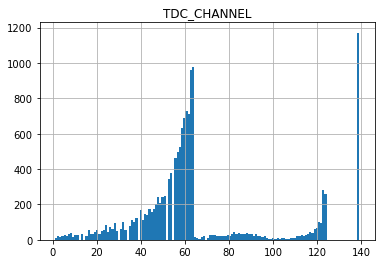

FPGA==1


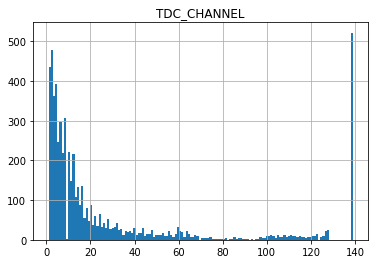

In [9]:
print("FPGA==0")
data_N[data_N['FPGA']==0].hist("TDC_CHANNEL",bins=140)
plt.show()
print("FPGA==1")
data_N[data_N['FPGA']==1].hist("TDC_CHANNEL",bins=140)
plt.show()